In [14]:
import numpy as np
from matplotlib import pyplot as plt
from tqdm import tqdm
import jax.numpy as jnp
import jax
from scipy.special import erfcinv
from functools import partial, wraps

In [15]:
import lib

In [25]:
class Simulation_Diffusion_Run():
    def __init__(self, neuron: lib.Neuron, xs_gen: lib.Xs_Generator, decay_steps=500, initial_steps=500, n_tested_patterns=100, refresh_every=1000, seed=42) -> None:
        self.key = jax.random.PRNGKey(seed)
        self.key, subkey1, subkey2 = jax.random.split(self.key, 3)
        self.neuron = neuron
        self.decay_steps = decay_steps
        self.initial_steps = initial_steps
        self.n_test_patterns = n_tested_patterns
        self.refresh_every = max(refresh_every, n_tested_patterns)
        self.xs_gen = xs_gen
        self.xs = self.xs_gen.gen(subkey1, self.refresh_every)
        self.init_w(subkey2)
        self.w0 = self.neuron.w
        # self.w0 = self.w0/jnp.linalg.norm(self.w0, axis=-1, keepdims=True)

        self.overlaps_record = np.zeros((self.neuron.nd, decay_steps))

    @partial(jax.jit, static_argnums=(0, ))
    def neuron_update_fun(self, w, x, latent_var):
        return self.neuron.update_fun(w, x, latent_var)

    def init_w(self, key):
        for i  in range(self.initial_steps):
            if i%self.refresh_every == 0:
                subkey, key = jax.random.split(key)
                xs0 = self.xs_gen.gen(subkey, self.refresh_every)
            self.neuron.w, self.neuron.latent_var = self.neuron_update_fun(self.neuron.w, xs0[i%self.refresh_every], self.neuron.latent_var)
        
        self.w0 = xs0[-1]

    @partial(jax.jit, static_argnums=(0, ))
    def _update_and_get_overlaps(self, w, latent_var, x):
        overlaps = jnp.sum(w*self.w0, axis=-1)/jnp.linalg.norm(self.w0, axis=-1) # dim=(nd, ) overlap = w dot (unit vector w0)
        w, latent_var = self.neuron_update_fun(w, x, latent_var)
        return w, latent_var, overlaps

    def run(self, progress_bar=True):        
        if progress_bar is True: 
            pb = tqdm(range(self.decay_steps))
        else:
            pb = range(self.decay_steps)
        for i in pb:
            if i%self.refresh_every == 0 and i>=self.refresh_every:
                self.key, subkey = jax.random.split(self.key)
                self.xs = self.xs_gen.gen(subkey, self.refresh_every)
            self.neuron.w, self.neuron.latent_var, overlaps = self._update_and_get_overlaps(self.neuron.w, self.neuron.latent_var, self.xs[i%self.refresh_every])
            self.overlaps_record[..., i] = overlaps

In [26]:
ns=300
nd=200
rho=1
bias = 2.75
ndR = 4
kappa = 2.25
n_votes = nd
vote_th = bias
la = bias - np.sqrt(2)*erfcinv(2*ndR/nd)
beta = 9.62281

decay_steps = 5000
n_tested_patterns = 1000
initial_steps = 5000

seed = 29
rng = np.random.default_rng(seed)

neuron = lib.Neuron10_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, ndR=ndR, beta=beta, vote_th=vote_th, seed=rng.integers(100000))
# neuron = lib.Neuron3_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, ndR=ndR, n_votes=n_votes, vote_th=vote_th, seed=rng.integers(100000))
# neuron = lib.Neuron4_2(n_synapses=ns, n_dendrites=nd, bias=bias, kappa=kappa, la=la, n_votes=n_votes, vote_th=vote_th, seed=rng.integers(100000))

xs_gen = lib.Xs_Generator1(nd, ns, normalized_len=np.sqrt(ns), seed=rng.integers(100000))
# xs_gen = lib.Xs_Generator3_2(1, ns, rho, normalized_len=np.sqrt(ns), seed=rng.integers(100000))

simulation_run = Simulation_Diffusion_Run(neuron, xs_gen, decay_steps=decay_steps, initial_steps=initial_steps, n_tested_patterns=n_tested_patterns, refresh_every=500, seed=rng.integers(100000))

In [27]:
simulation_run.run()

100%|██████████| 5000/5000 [00:09<00:00, 504.28it/s]


In [28]:
tList = np.arange(0, decay_steps, 1)
normalized_record = simulation_run.overlaps_record/(np.linalg.norm(simulation_run.w0, axis=-1).reshape((-1, 1)))
mean_record = np.mean(normalized_record, axis=0)

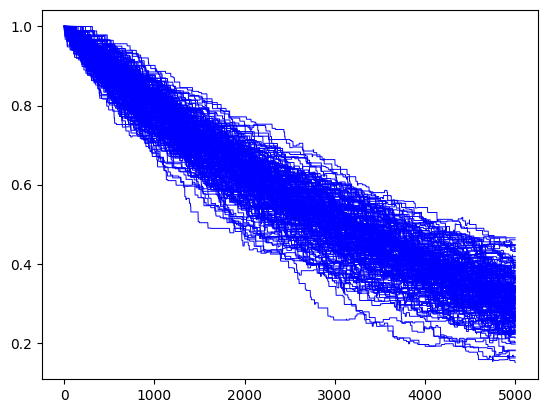

In [29]:
for i in range(nd):
    plt.plot(normalized_record[i], c="blue", linewidth=0.7)
    # plt.plot(simulation_run.overlaps_record[i], c="blue", linewidth=0.7)

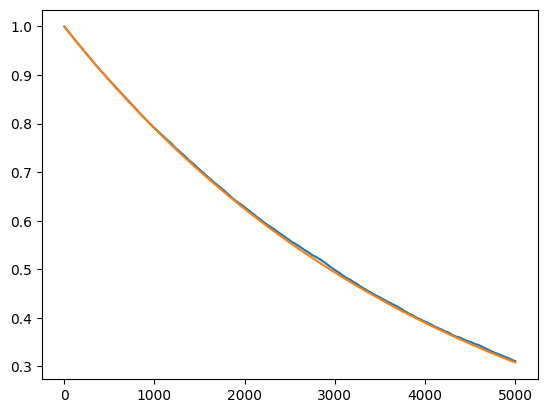

In [30]:
plt.plot(mean_record)
plt.plot(tList, np.exp(-0.070673/ns*tList))

In [35]:
tmp_record = simulation_run.overlaps_record/np.linalg.norm(simulation_run.w0, axis=-1).reshape((-1, 1)) - mean_record
g1 = 0.07067302559514269
# tmp_record = (simulation_run.overlaps_record - simulation_run.overlaps_record[:, 0].reshape((-1, 1))*np.exp(-g1*tList/ns))*np.sqrt(ns)

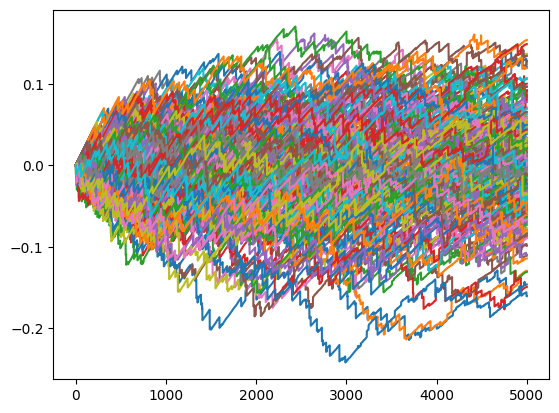

In [36]:
for i in range(nd):
    plt.plot(tmp_record[i, :])

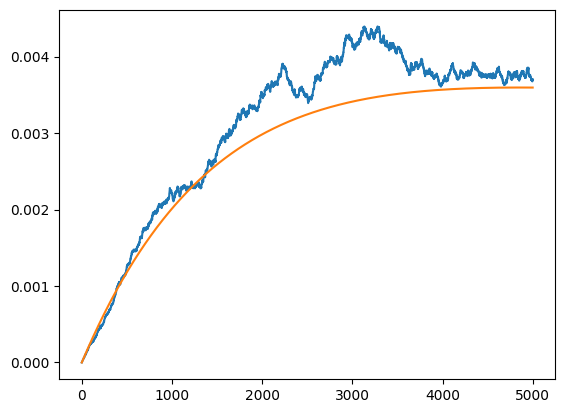

In [37]:
plt.plot(np.var(tmp_record, axis=0))
g1 = 0.07067302559514269
g2 = 0.1409797196083666
theory_var = 1/ns - np.exp(-g2/ns*tList)/ns + np.exp(-g2/ns*tList) - np.exp(-2*g1/ns*tList)
# theory_var = 1 - np.exp(-g2/ns*tList)
plt.plot(tList, theory_var)